In [1]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from matplotlib import cm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

sns.set()

In [2]:
# minst를 어디에 다운 받을지
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# 사전 학습된 모듈이 다운로드 될 경로
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/InitOptim/")

# 시드 설정 
L.seed_everything(42)

# 재현성을 위해 모든 작업이 gpu에서 결정적인지 확인
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# cuda 사용 안되면 cpu에서 
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cuda:0


In [3]:
# Github URL, 이 튜토리얼을 위한 저장된 모델있음
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = [
    "FashionMNIST_SGD.config",
    "FashionMNIST_SGD_results.json",
    "FashionMNIST_SGD.tar",
    "FashionMNIST_SGDMom.config",
    "FashionMNIST_SGDMom_results.json",
    "FashionMNIST_SGDMom.tar",
    "FashionMNIST_Adam.config",
    "FashionMNIST_Adam_results.json",
    "FashionMNIST_Adam.tar",
]
# 체크포인트 생성 경로, 폴더가 존재하지 않을 경우 
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 파일이 존재하지 않을 경우 다운로드
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "뭔가 잘못됨, GD드라이브로 다운 바람, 또는 오류메시지를 저자에게 보내주세요:\n",
                e,
            )

In [4]:
# 각 이미지에 변형 적용, 1. 텐서 만들기, 2 평균 0 분산 1인 정규화 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# 트레이닝 데이터셋 로딩, 트레인 데이터랑 평가 데이터로 나눠준다
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# 테스트 데이터 로딩
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

<pre>
데이터 로더 정의, 나중에 사용하기 편하게
트레이닝 모델에 사용할 배치 만들기

</pre>

In [5]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

대부분의 분류 작업에서  정규화 기술이 효과가 좋음</br>
그래서 평균과 표준편차를 사용할 거임

In [6]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [7]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


In [8]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        
        # hidden_size: 히든층의 크기를 정하는 정수 목록
        super().__init__()

        # 정의된 은닉층으로 네트워크 생성
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        #  layers 리스트를 nn.ModuleList로 감싸서 모델의 층들을 관리
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
# 활성화 함수 정의
class Identity(nn.Module):
    def forward(self, x):
        return x


act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "identity": Identity}

In [10]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # 차이가 있은 경우 kde 그리기
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig





def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # 그리기
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()





def visualize_gradients(model, color="C0", print_variance=False):
  
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # 네트워크로 하나의 배치 통과, 가중치 업글을 위한 그래디언트 계산
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  #  손실함수
    loss.backward()
    # 가중치 파라미터와 편향을 줄임, 그래프의 수를 줄이기 위해
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # 그리기
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")





def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")




In [11]:
model = BaseNetwork(act_fn=Identity()).to(device)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

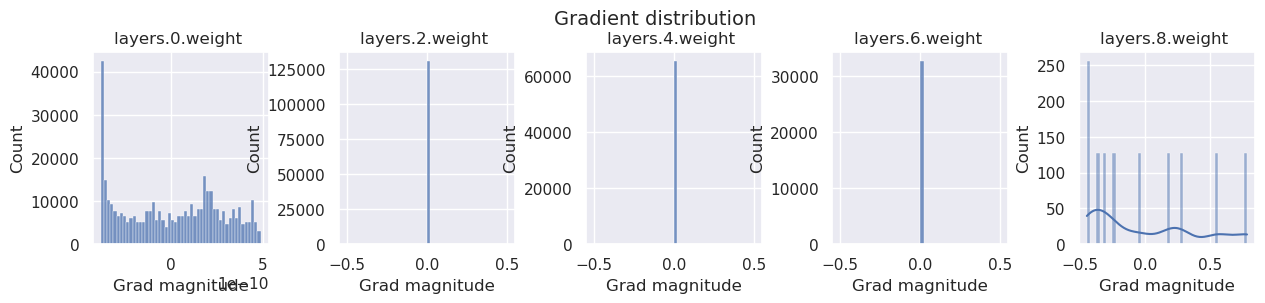

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

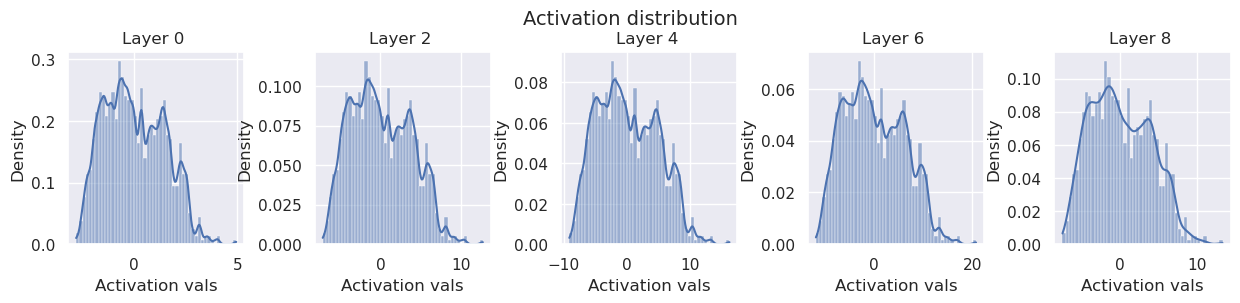

Layer 0 - Variance: 2.0582759380340576
Layer 2 - Variance: 13.489119529724121
Layer 4 - Variance: 22.100566864013672
Layer 6 - Variance: 36.209571838378906
Layer 8 - Variance: 14.831440925598145


In [12]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)


const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

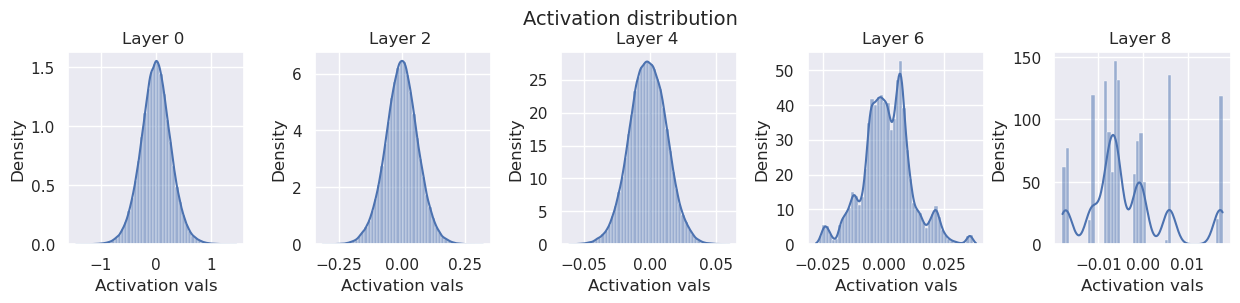

Layer 0 - Variance: 0.07577288150787354
Layer 2 - Variance: 0.004244204144924879
Layer 4 - Variance: 0.00019484871882013977
Layer 6 - Variance: 0.00010494683374417946
Layer 8 - Variance: 8.410162263317034e-05


In [13]:
# 무작위로 샘플링하여 매개변수초기화 
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)


var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

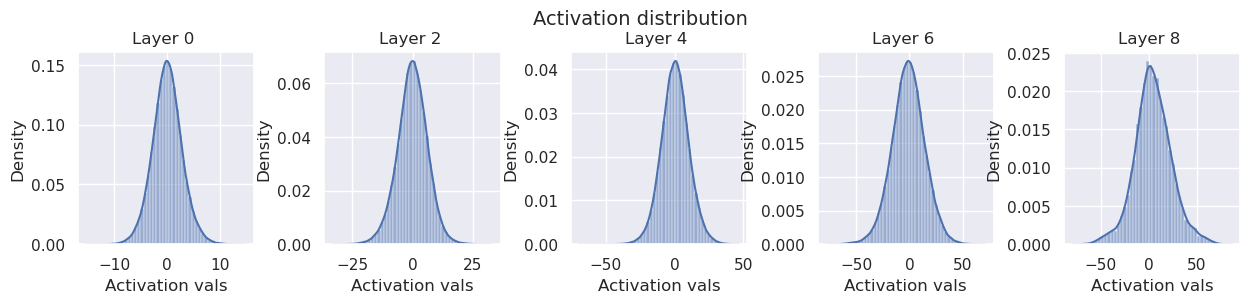

Layer 0 - Variance: 7.824342727661133
Layer 2 - Variance: 39.03034591674805
Layer 4 - Variance: 101.69364166259766
Layer 6 - Variance: 238.3145294189453
Layer 8 - Variance: 372.36492919921875


In [14]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

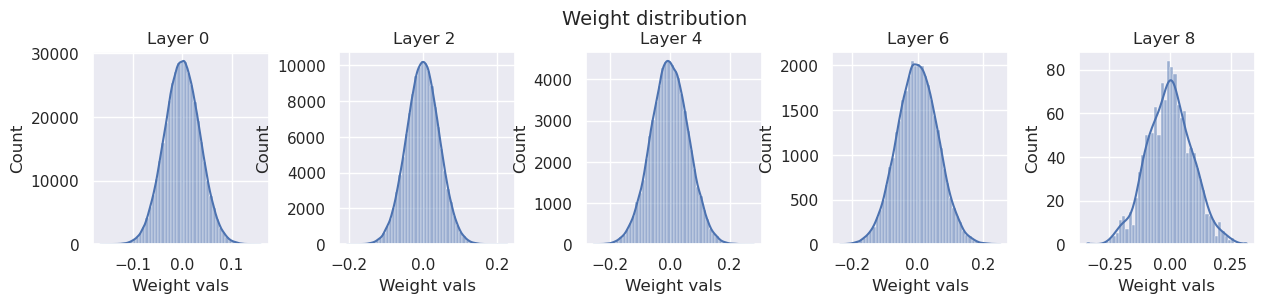

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

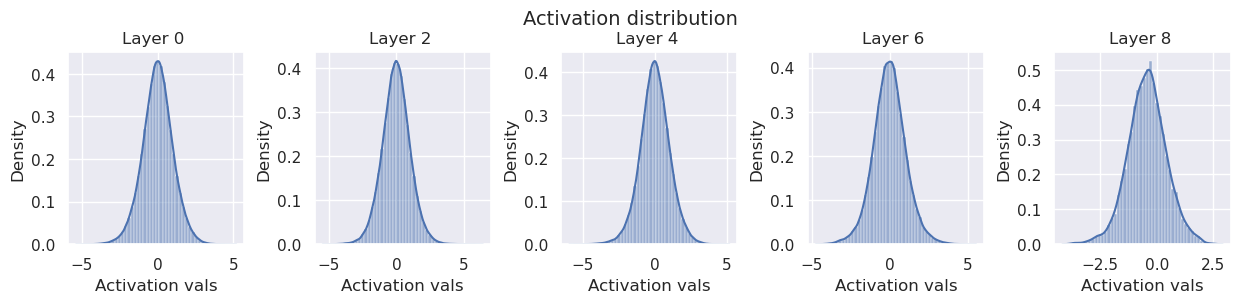

Layer 0 - Variance: 1.0054991245269775
Layer 2 - Variance: 1.0706968307495117
Layer 4 - Variance: 1.0502846240997314
Layer 6 - Variance: 1.092429280281067
Layer 8 - Variance: 0.7355986833572388


In [15]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))


equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

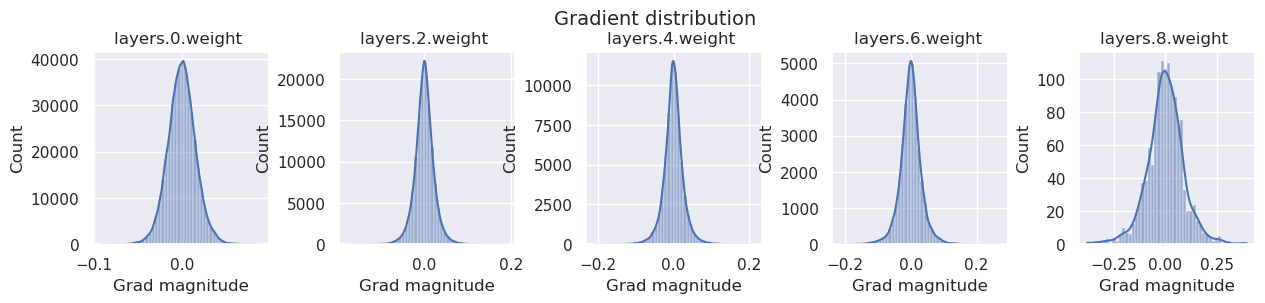

layers.0.weight - Variance: 0.0002527024189475924
layers.2.weight - Variance: 0.0004820353933610022
layers.4.weight - Variance: 0.0006816114182583988
layers.6.weight - Variance: 0.0010799441952258348
layers.8.weight - Variance: 0.007923619821667671


/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

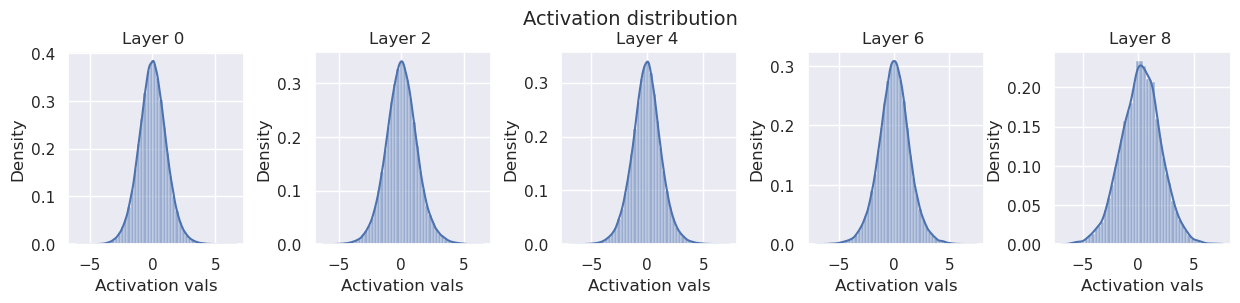

Layer 0 - Variance: 1.2380084991455078
Layer 2 - Variance: 1.6150164604187012
Layer 4 - Variance: 1.6970887184143066
Layer 6 - Variance: 2.0189461708068848
Layer 8 - Variance: 3.2689921855926514


In [16]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

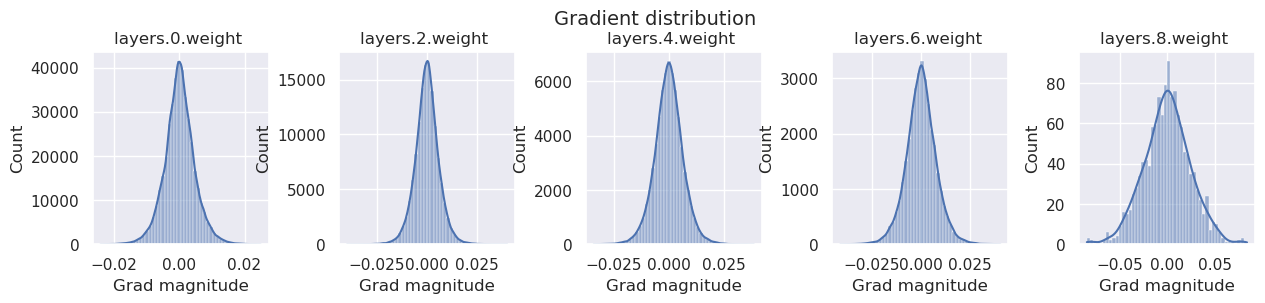

layers.0.weight - Variance: 2.1564574126387015e-05
layers.2.weight - Variance: 3.486976129352115e-05
layers.4.weight - Variance: 4.1780556784942746e-05
layers.6.weight - Variance: 5.815719850943424e-05
layers.8.weight - Variance: 0.0005967225879430771


/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

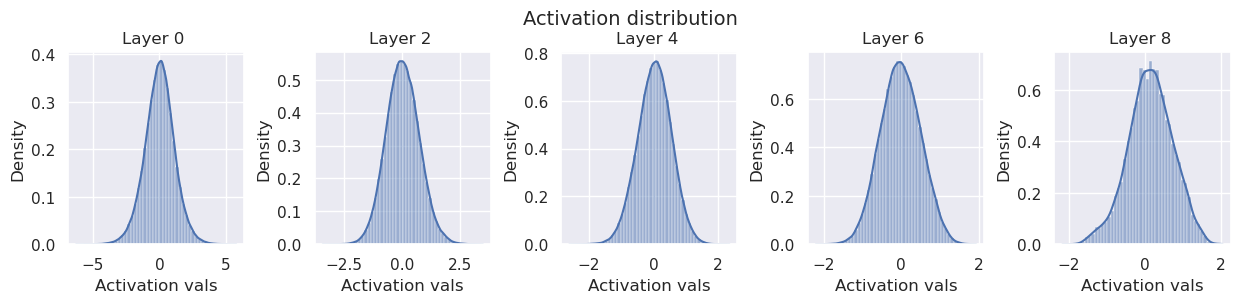

Layer 0 - Variance: 1.2519282102584839
Layer 2 - Variance: 0.5061986446380615
Layer 4 - Variance: 0.27336668968200684
Layer 6 - Variance: 0.26534587144851685
Layer 8 - Variance: 0.34700536727905273


In [17]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

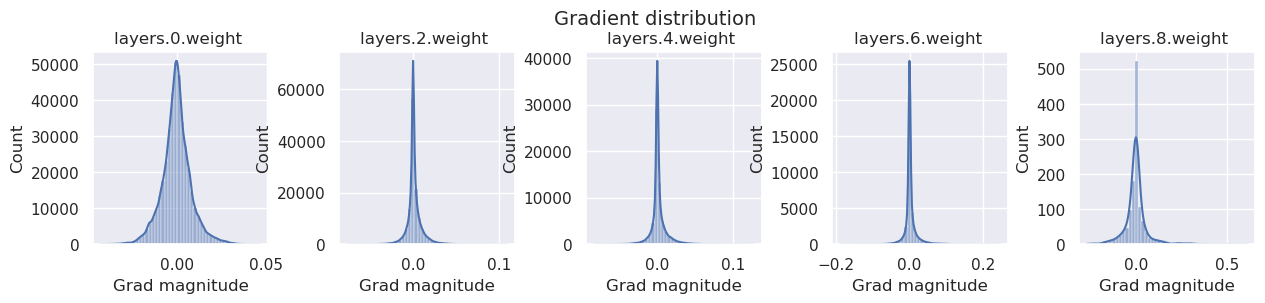

layers.0.weight - Variance: 6.704074621666223e-05
layers.2.weight - Variance: 8.035500650294125e-05
layers.4.weight - Variance: 0.00011357852054061368
layers.6.weight - Variance: 0.00032811856362968683
layers.8.weight - Variance: 0.004723516292870045


/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

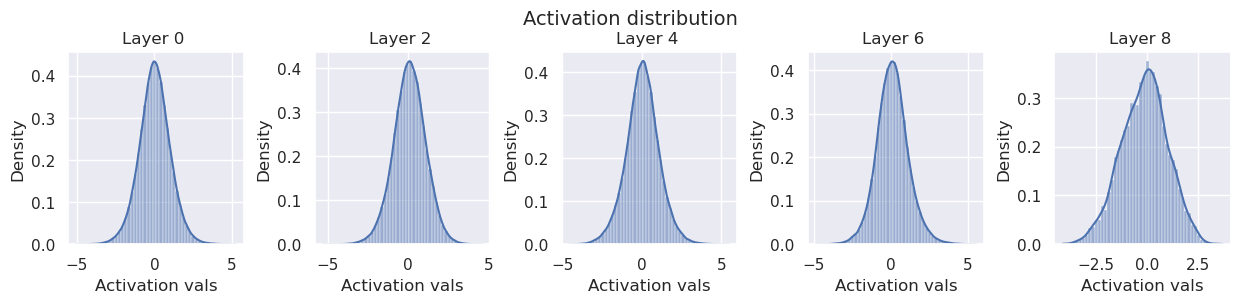

Layer 0 - Variance: 0.9987749457359314
Layer 2 - Variance: 1.00645112991333
Layer 4 - Variance: 1.0764902830123901
Layer 6 - Variance: 1.0629653930664062
Layer 8 - Variance: 1.298248529434204


In [18]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):  # 첫 번째 레이어는 ReLU를 가지지 않습니다, 입력값이 적용된
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))


model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

In [19]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")


def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")


def load_model(model_path, model_name, net=None):
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f' 찾을 수 없다, config file "{config_file}". 경로 제대로 설정한거 맞나?'
    assert os.path.isfile(
        model_file
    ), f'찾을 수 없다, model file "{model_file}". 경로 제대로 설정한거 맞나?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert (
            act_fn_name in act_fn_by_name
        ), f'정체불명의 활성화 함수 "{act_fn_name}". 딕셔너리의 "act_fn_by_name"에 추가해 주세요 .'
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net


def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)


def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
   

   
        # model_name: 모델이름 체크포인트의 이름 짓기 위해 사용
        
        #overwrite: 체크 포인트가 이미 존재할 때 덮어씌울지(True) 스킵(False)할지 정하는 인자.
    
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f' "{model_name}"있음, 훈련 건너 뜀 ')
        with open(_get_result_file(CHECKPOINT_PATH, model_name)) as f:
            results = json.load(f)
    else:
        if file_exists:
            print("덮어씌우는 중...")

        # 최적화,손실 데이터 로더 정의
        optimizer = optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            train_acc, val_acc, epoch_losses = epoch_iteration(
                net, loss_module, optimizer, train_loader_local, val_loader, epoch
            )
            train_scores.append(train_acc)
            val_scores.append(val_acc)
            train_losses += epoch_losses

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (좋은 성능을 내는 모델 저장)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {
            "test_acc": test_acc,
            "val_scores": val_scores,
            "train_losses": train_losses,
            "train_scores": train_scores,
        }
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # 평가 정확도 그리기
    sns.set()
    plt.plot([i for i in range(1, len(results["train_scores"]) + 1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1, len(results["val_scores"]) + 1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"]) * 1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=") + "\n")
    return results


def epoch_iteration(net, loss_module, optimizer, train_loader_local, val_loader, epoch):
    net.train()
    true_preds, count = 0.0, 0
    epoch_losses = []
    t = tqdm(train_loader_local, leave=False)
    for imgs, labels in t:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = net(imgs)
        loss = loss_module(preds, labels)
        loss.backward()
        optimizer.step()
        # 훈련하는 동안 통계 기록
        true_preds += (preds.argmax(dim=-1) == labels).sum().item()
        count += labels.shape[0]
        t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
        epoch_losses.append(loss.item())
    train_acc = true_preds / count

    
    val_acc = test_model(net, val_loader)
    print(
        f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
    )
    return train_acc, val_acc, epoch_losses


def test_model(net, data_loader):
  
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [20]:
class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        # 모든 파라미터의 그래디언트를 0으로
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()  #그래디언트 분리하여 역전파 사용하지 않음.
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        # 매개변수 업데이트
        for p in self.params:
            if p.grad is None:  # 그래디언트 없는 파라미터 건너뛰기
                continue
            self.update_param(p)

    def update_param(self, p):
        # 최적화-정의 분류 구현
        raise NotImplementedError

In [21]:
class SGD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update)  # 내부 업데이트, 메모리를 절약하고 계산 그래프 생성 안함


In [22]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum  # 모멘텀 계수 설정, 모멘텀 계수가 0에 가까울 수록 업데이트 방향이 덜 영향을 받아 더 부드러운 업데이트가 이뤄진다
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}  # 파라미터의 모멘텀 값을 저장하기 위한 딕셔너리인 self.param_momentum 초기화

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

In [23]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params}  
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad) ** 2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

In [24]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 256, 256, 128])
kaiming_init(base_model)

 "FashionMNIST_SGD"있음, 훈련 건너 뜀 


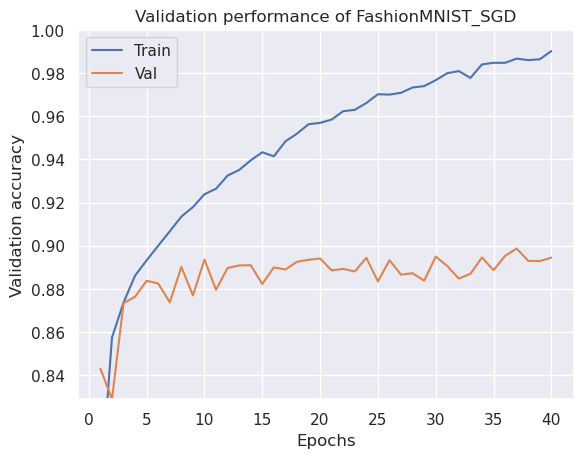

============= Test accuracy: 89.09% ==============



In [25]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(
    SGD_model, "FashionMNIST_SGD", lambda params: SGD(params, lr=1e-1), max_epochs=40, batch_size=256
)

 "FashionMNIST_SGDMom"있음, 훈련 건너 뜀 


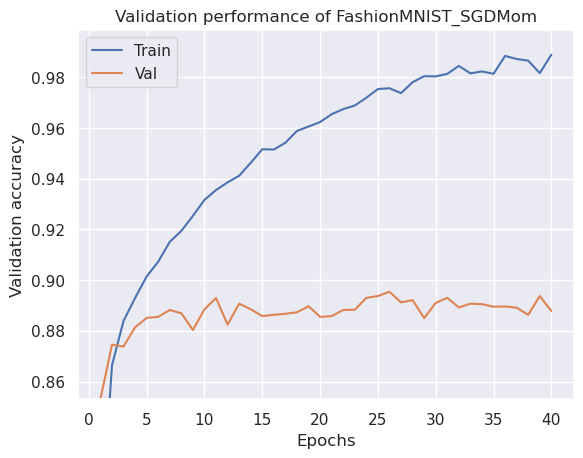

============= Test accuracy: 88.83% ==============



In [26]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(
    SGDMom_model,
    "FashionMNIST_SGDMom",
    lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
    max_epochs=40,
    batch_size=256,
)

 "FashionMNIST_Adam"있음, 훈련 건너 뜀 


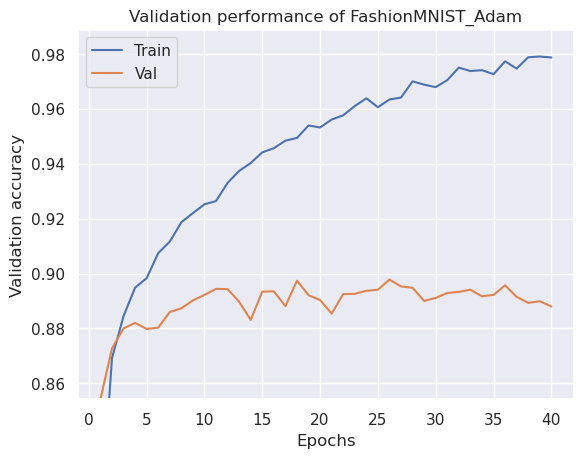

============= Test accuracy: 89.46% ==============



In [27]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(
    Adam_model, "FashionMNIST_Adam", lambda params: Adam(params, lr=1e-3), max_epochs=40, batch_size=256
)

In [28]:
def pathological_curve_loss(w1, w2):
    x1_loss = torch.tanh(w1) ** 2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

/root/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


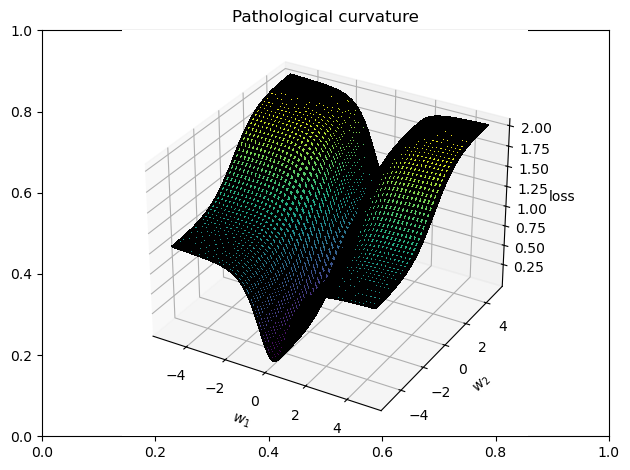

In [29]:
def plot_curve(
    curve_fn, x_range=(-5, 5), y_range=(-5, 5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"
):
    fig = plt.figure()
    ax = fig.gca()
    if plot_3d:
        ax = fig.add_subplot(projection="3d")

    x = torch.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / 100.0)
    y = torch.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / 100.0)
    x, y = torch.meshgrid([x, y]) # x와 y에 저장된 등간격 값들을 이용하여 2차원 그리드 생성
    z = curve_fn(x, y) # x와 y의 입력을 통해 z값을 계싼
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax


sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [30]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5, 5]):
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optim = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0)) # 0차원 즉 행 추가 ,기존의 텐서값이 복제되서 들어감
        optim.zero_grad()
        loss.backward()
        optim.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [31]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

# 최적화 알고리즘을 통해 훈련 곡선 생성
# 훈련곡선이란?->학습 과정에서 손실이나 정확도와 같은 지표를 시간에 따라 변화하는 추이를 나타내는 그래프



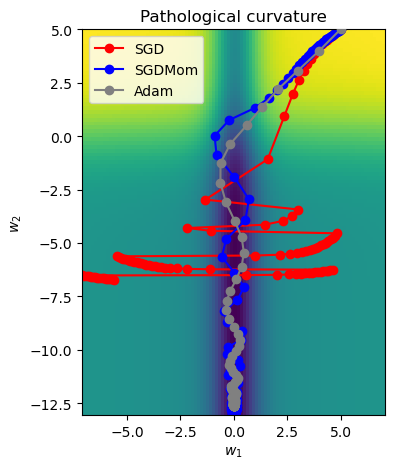

In [32]:
# 업데이트 단계를 손실 표면을 통한 선 플롯으로 시각화
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(
    pathological_curve_loss,
    x_range=(-np.absolute(all_points[:, 0]).max(), np.absolute(all_points[:, 0]).max()),
    y_range=(all_points[:, 1].min(), all_points[:, 1].max()),
    plot_3d=False,
)
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

손실표면에서 기울기가 급격하게 변한다는 것은 </br>
손실 함수가 급격하게 변한다는 것 이고 </br>
이는 최적화 과정이 불안정해진다는 것이다


In [33]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean) ** 2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean) ** 2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)


def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z


_ = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=True, title="Steep optima")

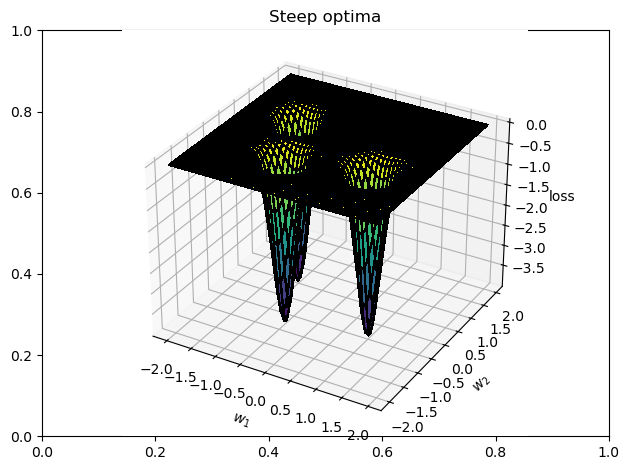

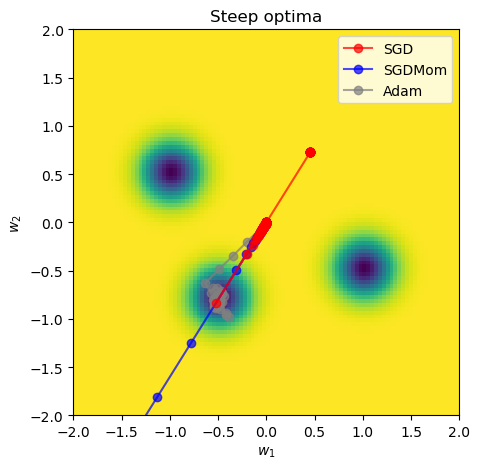

In [34]:
SGD_points = train_curve(lambda params: SGD(params, lr=0.5), comb_func, init=[0, 0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0, 0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0, 0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func, x_range=(-2, 2), y_range=(-2, 2), plot_3d=False, title="Steep optima")
ax.plot(SGD_points[:, 0], SGD_points[:, 1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:, 0], SGDMom_points[:, 1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:, 0], Adam_points[:, 1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()